# Link Prediction in Bipartite Graph

* spectral transformation technique ?!

## Import dependencis

In [1]:
import networkx as nx
import random
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
from sklearn import metrics
from scipy.optimize import curve_fit
from tqdm import tqdm

### Create Bipartite Graph.

In [12]:
G = nx.bipartite.gnmk_random_graph(15, 10, 50 ,seed=2022)

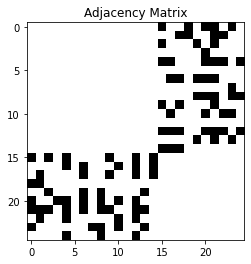

<Figure size 1080x720 with 0 Axes>

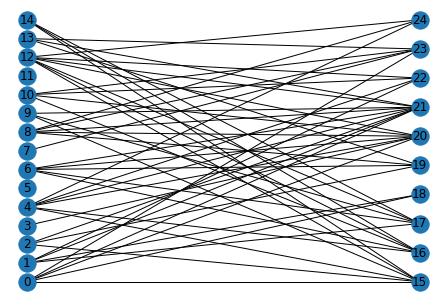

In [25]:
''' 
error occurs here ; Disconnected graph error
top = nx.bipartite.sets(G)[0]
'''

# from stackoverflow 
u = [n for n in G.nodes if G.nodes[n]['bipartite'] == 0]
nx.bipartite.maximum_matching(G, top_nodes=u) # solution
pos = nx.bipartite_layout(G, u)

A = nx.adjacency_matrix(G)
A = A.toarray()

plt.title('Adjacency Matrix')
plt.imshow(A, cmap='Greys')
plt.figure(figsize=(15,10))
plt.show()

nx.draw(G, pos, with_labels=True)

#### spliting

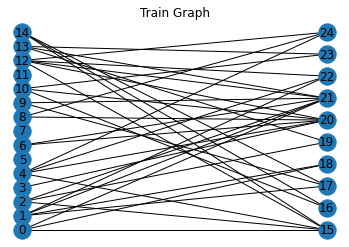

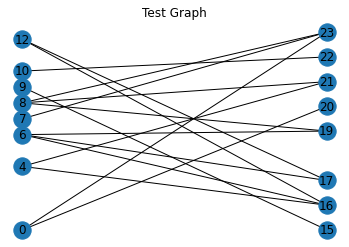

In [32]:
###
proportion_edges = 0.3
edge_subset = random.sample(G.edges(), int(proportion_edges * G.number_of_edges()))

G_train = G.copy()
G_train.remove_edges_from(edge_subset)

A_train = nx.adjacency_matrix(G_train)
A_train = A_train.toarray()

plt.title('Train Graph')
nx.draw(G_train, pos, with_labels=True)
plt.show()

###
G_test = nx.Graph()
G_test.add_edges_from(edge_subset)

plt.title('Test Graph')
nx.draw(G_test, pos, with_labels=True)
plt.show()

### Evaluation Metric

In [73]:
def MAP(G_test, G_pred, thres=0):
    avePs = []
    for node in tqdm(G_test.nodes()):
        
        rankedPredWeights = sorted(G_pred[node].items(), key=lambda x: -x[1]['weight'])
        rankedPred = filter(lambda x: x[1]['weight'] > thres, rankedPredWeights)
        pred = [x[0] for x in rankedPred]
        
        gt = set(G_test[node])
        rel = np.array([x in gt for x in pred])
        
        predLength = len(pred)
        P = np.array([
            sum(rel[:i+1]) / len(rel[:i+1]) for i in range(predLength)
        ])
        
        aveP = (rel @ P) / len(gt)
        
        avePs.append(aveP)
    
    MAPvalue = sum(avePs) / len(avePs)
    
    print(f"MAP: {MAPvalue}")
    
    return MAPvalue

In [71]:
def ROC_PRC(pred, G):
    y_score = [p[2] for p in pred]
    y_true = [G.has_edge(p[0], p[1]) for p in pred]
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    fpr, tpr, thresholds = metrics.precision_recall_curve(y_true, y_score)
    ax1.plot(fpr, tpr)
    ax1.set_title('precision-recall curve')
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    ax2.plot(fpr, tpr)
    ax2.set_title(f'ROC curve, auc = {metrics.roc_auc_score(y_true, y_score):.2f}')
    
    plt.show()

### Neighbours-based Techniques

In [58]:
def allOnes(G_train):
    N = len(G_train.nodes())
    pred = [(i, j, 1) for i in range(N) for j in range(N)]
    
    return pred

<function allOnes at 0x7ff235084af0>


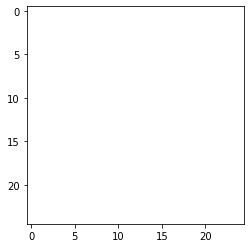

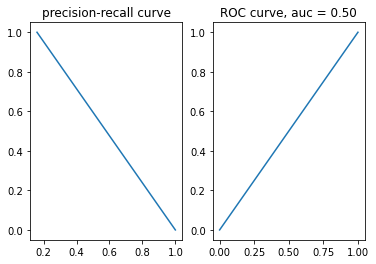

100%|██████████| 16/16 [00:00<00:00, 994.22it/s]

MAP: 0.1917345713601308
<function resource_allocation_index at 0x7ff23b5a6b80>


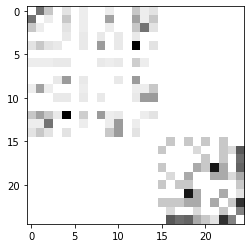

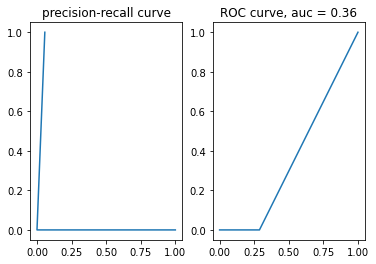

100%|██████████| 16/16 [00:00<00:00, 7471.48it/s]

MAP: 0.0
<function jaccard_coefficient at 0x7ff23b5a6f70>


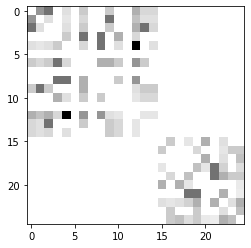

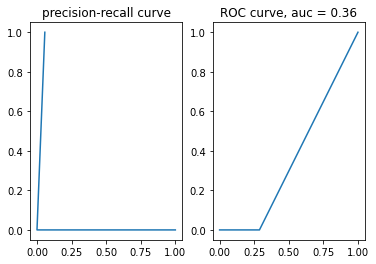

100%|██████████| 16/16 [00:00<00:00, 1448.62it/s]

MAP: 0.0
<function adamic_adar_index at 0x7ff23b5ad3a0>


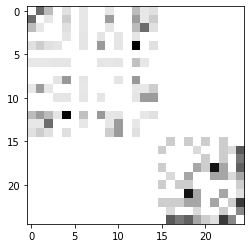

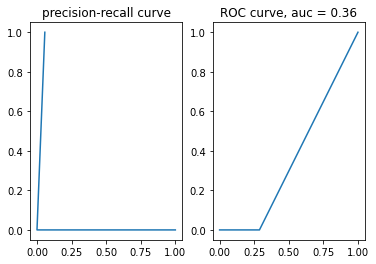

100%|██████████| 16/16 [00:00<00:00, 8368.73it/s]

MAP: 0.0


In [74]:
for algo in [
    allOnes,
    nx.resource_allocation_index,
    nx.jaccard_coefficient,
    nx.adamic_adar_index
]:
    print(algo)
    pred = list(algo(G_train))
    
    G_pred = nx.Graph()
    G_pred.add_weighted_edges_from(pred)
    
    Apred = nx.adjacency_matrix(G_pred)
    Apred = Apred.toarray()
    plt.imshow(Apred, cmap='Greys')
    plt.show()
    
    ROC_PRC(pred, G)
    MAP(G_test , G_pred)

### Spectral Curve Fitting

- explain what is spectral transformation and eigenvalue decomposition

- explain kernel and why odd paths

- explain curve fitting problem and prediction task

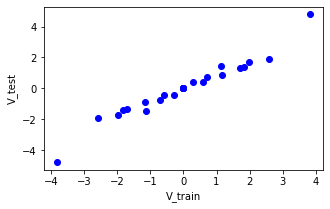

In [76]:
V_train, U_train = np.linalg.eig(A_train)

target_V = U_train.T @ A @ U_train

target_V = np.diag(target_V)

plt.figure(figsize=(5, 3))
plt.xlabel('V_train')
plt.ylabel('V_test')
plt.scatter(V_train, target_V, c='b')
plt.show()

In [82]:
class OddPathCountingKernel:
    def __init__(self):
        self.a1 = 0
        self.a3 = 0
        self.a5 = 0
        self.a7 = 0
        
    def func(self, V, a1, a3, a5, a7):
        return V * a1 + V**3 * a3 + V**5 * a5 + V**7 * a7

    def fit(self, V_train, target_V):
        popt, pcov = curve_fit(self.func, V_train, target_V)
        self.a1, self.a3, self.a5, self.a7 = popt
        
    def pred(self, V_train):
        return self.func(V_train, self.a1, self.a3, self.a5, self.a7)

In [80]:
class SinhPseudokernel:
    def __init__(self):
        self.alpha = 0
        
    def func(self, V, alpha):
        return np.array([
            alpha * (np.exp(lamb) - np.exp(-lamb)) for lamb in V
        ])
    
    def fit(self, V_train, target_V):
        popt, pcov = curve_fit(self.func, V_train, target_V)
        self.alpha, = popt
        
    def pred(self, V_train):
        return self.func(V_train, self.alpha)

In [85]:
class OddNeumannPseudokernel:
    def __init__(self):
        self.alpha = 0
        
    def func(self, V, alpha):
        return np.array([
            alpha * (1/(1-lamb) - 1/(1+lamb)) for lamb in V
        ])
    
    def fit(self, V_train, target_V):
        popt, pcov = curve_fit(self.func, V_train, target_V)
        self.alpha, = popt
        
    def pred(self, V_train):
        return self.func(V_train, self.alpha)

/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/conda/lib/python3.8/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


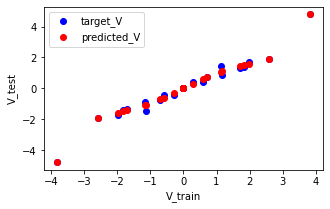

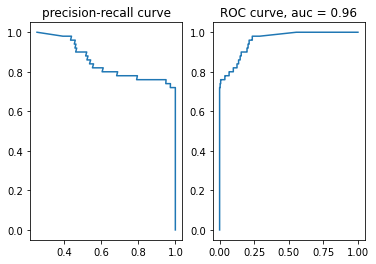

100%|██████████| 16/16 [00:00<00:00, 4266.84it/s]

MAP: 0.18839699074074073



/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/conda/lib/python3.8/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


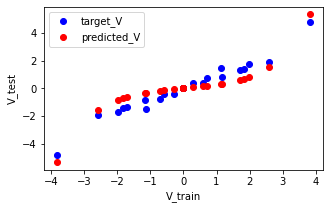

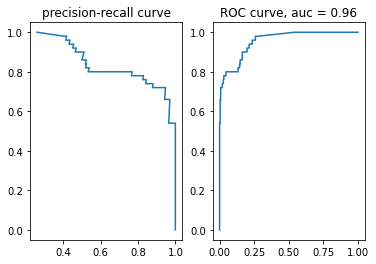

100%|██████████| 16/16 [00:00<00:00, 4485.59it/s]

MAP: 0.18949427308802308



/opt/conda/lib/python3.8/site-packages/numpy/lib/function_base.py:486: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)
/opt/conda/lib/python3.8/site-packages/matplotlib/collections.py:206: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


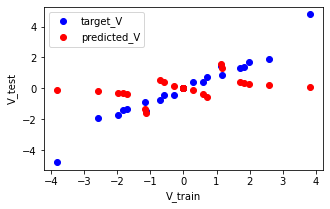

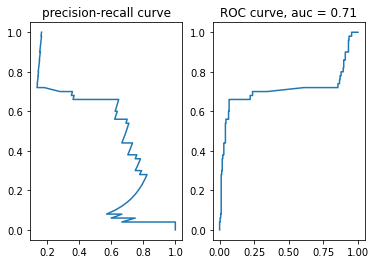

100%|██████████| 16/16 [00:00<00:00, 3985.09it/s]

MAP: 0.13680555555555557


In [86]:
for kernel in [OddPathCountingKernel(), SinhPseudokernel(),OddNeumannPseudokernel()]:
    
    print(kernel)
    
    kernel.fit(V_train, target_V)
    V_pred = kernel.pred(V_train)
    
    plt.figure(figsize=(5,3))
    plt.xlabel('V_train')
    plt.ylabel('V_test')
    plt.scatter(V_train, target_V, c='b', label='target_V')
    plt.scatter(V_train, V_pred, c='r', label='predicted_V')
    plt.legend()
    plt.show()
    
    Apred = U_train @ np.diag(V_pred) @ U_train.T
    Apred = Apred.real
    
    pred = [(i, j, Apred[i, j]) for i in range(Apred.shape[0]) for j in range(Apred.shape[1])]
    
    G_pred = nx.Graph()
    G_pred.add_weighted_edges_from(pred)
    
    ROC_PRC(pred, G)
    MAP(G_test, G_pred)